#Import and Downlaod Library

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import PIL as image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, DataLoader
import os
import random
import shutil
from pathlib import Path
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import alexnet, AlexNet_Weights


#Load  data and augmentate  data 

In [13]:

# Define paths (use raw strings or double backslashes to avoid escape character issues)
original_data_dir = Path(r"C:\Desktop\CDCS6A\CSP650\Testing and development\Training")   # Original folder with two class subfolders
split_data_dir = Path(r"C:\Desktop\CDCS6A\CSP650\Testing and development\Testing")       # New folder to store split data

# Create train and test directories
train_dir = split_data_dir / 'train'
test_dir = split_data_dir / 'test'
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Set the split ratio
split_ratio = 0.8

# Initialize counters for dataset sizes
train_size = 0
test_size = 0

# List to store class names
class_names = []

# Loop over each class folder
for class_folder in original_data_dir.iterdir():
    if class_folder.is_dir():
        # Get class name and store it
        class_name = class_folder.name
        class_names.append(class_name)

        # Create class subdirectories in train and test folders
        train_class_dir = train_dir / class_name
        test_class_dir = test_dir / class_name
        train_class_dir.mkdir(parents=True, exist_ok=True)
        test_class_dir.mkdir(parents=True, exist_ok=True)

        # Get all images in the current class folder
        images = list(class_folder.glob("*"))
        random.shuffle(images)  # Shuffle to ensure random splitting

        # Split images
        split_index = int(len(images) * split_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Update dataset size counters
        train_size += len(train_images)
        test_size += len(test_images)

        # Copy images to train and test folders
        for img in train_images:
            shutil.copy(img, train_class_dir / img.name)
        for img in test_images:
            shutil.copy(img, test_class_dir / img.name)

# Print dataset statistics
print("Data split completed!")
print("Train dataset size:", train_size)
print("Test dataset size:", test_size)
print("Class names:", class_names)




Data split completed!
Train dataset size: 262
Test dataset size: 66
Class names: ['Cultivated Rice', 'Weedy Rice']


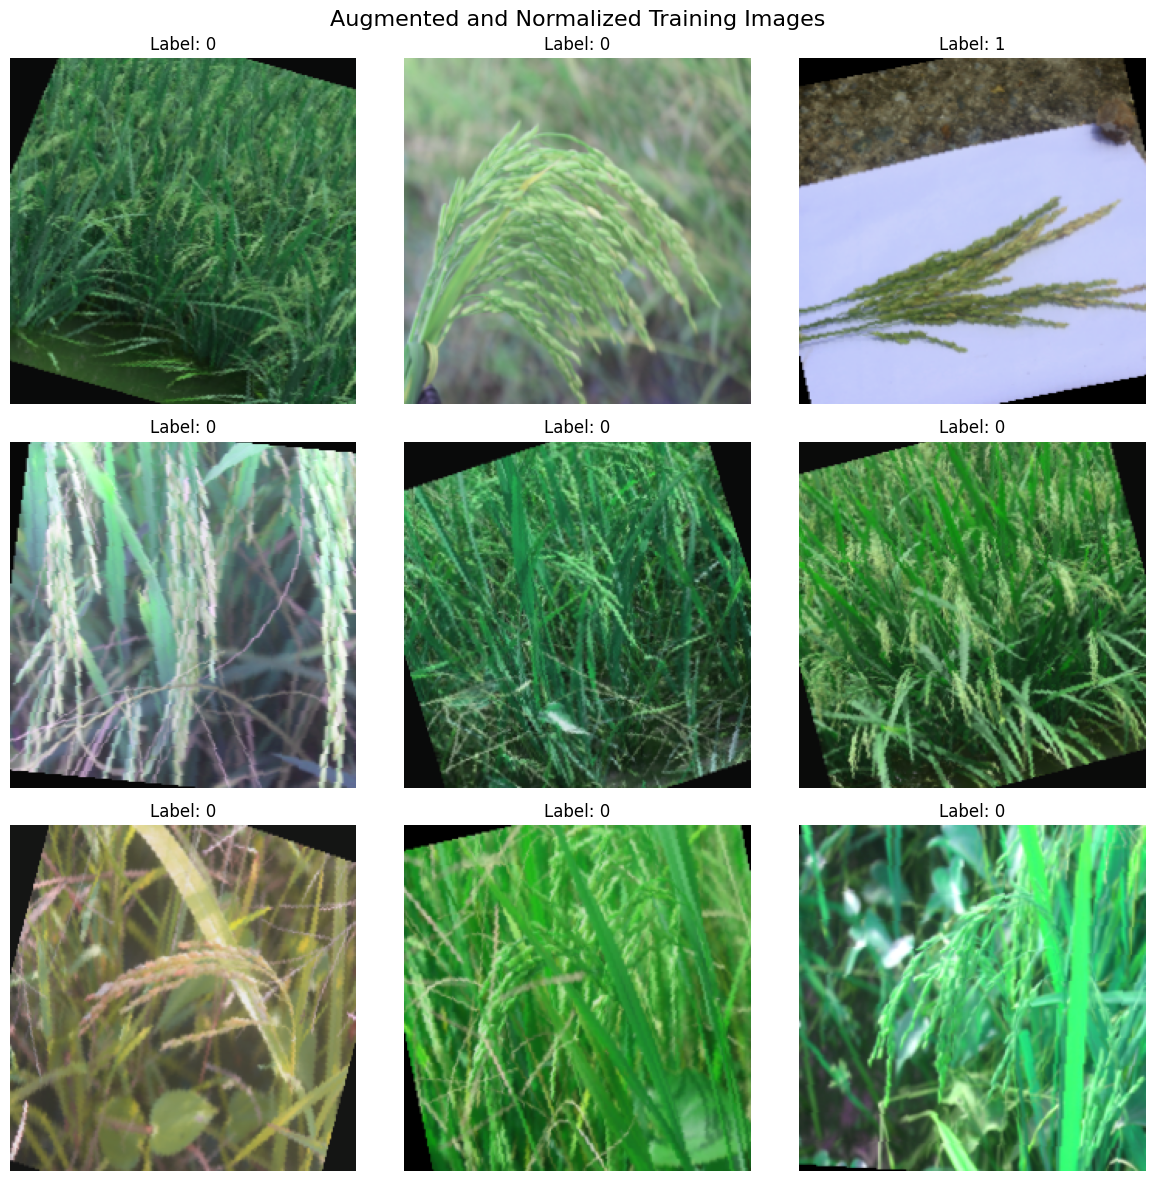

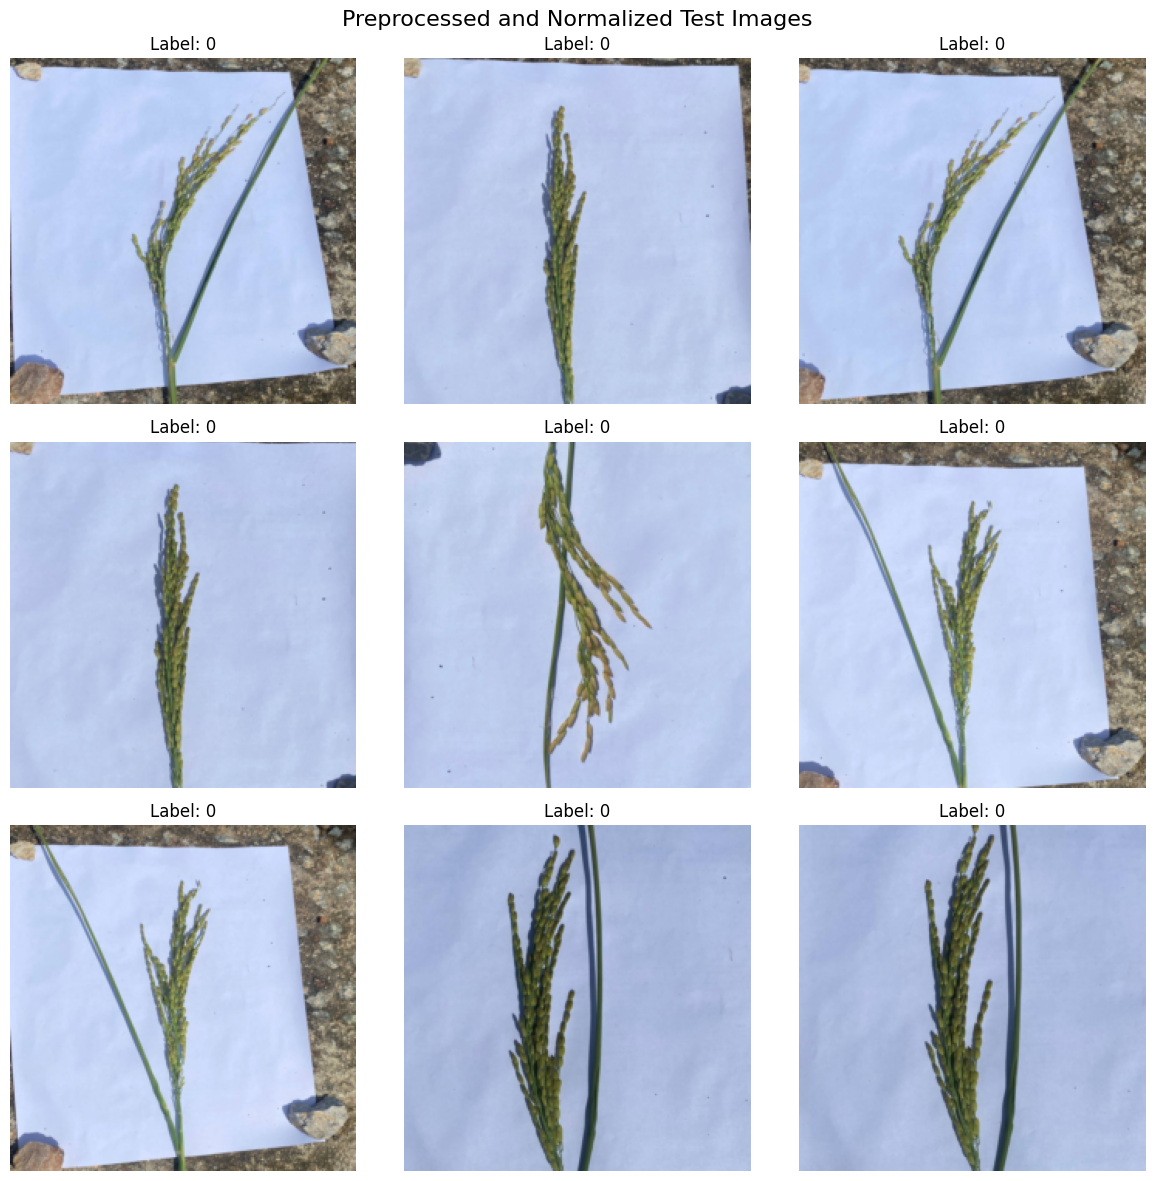

In [14]:
# Define mean and standard deviation for normalization (ImageNet values are common for pre-trained models)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transformations for the training set with data augmentation and normalization
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),  # Normalize images
])

# Create the ImageFolder dataset for training with augmentations
train_dataset = ImageFolder(root=train_dir, transform=data_transforms)

# Create DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Modify test dataset transformation to include resizing and normalization (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert PIL images to tensors
    transforms.Normalize(mean=mean, std=std),  # Normalize images
])

# Apply test_transforms to the test dataset
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to unnormalize and display images
def unnormalize_and_show_images(images, labels, title=None):
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )  # Inverse normalization to restore original image
    images = [inv_normalize(img) for img in images]
    
    plt.figure(figsize=(12, 12))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))  # Convert tensor to HWC format
        img = np.clip(img, 0, 1)  # Ensure pixel values are within [0, 1]
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Get a batch of training data
train_iter = iter(train_loader)
train_images, train_labels = next(train_iter)

# Visualize augmented and normalized training images (unnormalized for display)
unnormalize_and_show_images(train_images, train_labels, title="Augmented and Normalized Training Images")

# Get a batch of test data
test_iter = iter(test_loader)
test_images, test_labels = next(test_iter)

# Visualize preprocessed and normalized test images (unnormalized for display)
unnormalize_and_show_images(test_images, test_labels, title="Preprocessed and Normalized Test Images")



#Define The model to train 

In [15]:
# Ensure you have device set up correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3050 Laptop GPU


In [16]:

model = models.alexnet(weights=AlexNet_Weights.DEFAULT)
model


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:

num_classes = 2
num_features = model.classifier[6].in_features  # Get the input features of the last layer
model.classifier[6] = nn.Sequential(
    model.classifier[6],  # Keep the original fully connected layer
    nn.Dropout(p=0.5)  # Add a dropout layer with a dropout probability of 0.5
)
fc= model.classifier[6] = nn.Linear(in_features=num_features, out_features=num_classes)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
# eunsre that the model is unfrezzed
for param in model.parameters():
    param.requires_grad = True

for name, param in model.named_parameters():
    print(f"Layer: {name} | Frozen: {not param.requires_grad}")


Layer: features.0.weight | Frozen: False
Layer: features.0.bias | Frozen: False
Layer: features.3.weight | Frozen: False
Layer: features.3.bias | Frozen: False
Layer: features.6.weight | Frozen: False
Layer: features.6.bias | Frozen: False
Layer: features.8.weight | Frozen: False
Layer: features.8.bias | Frozen: False
Layer: features.10.weight | Frozen: False
Layer: features.10.bias | Frozen: False
Layer: classifier.1.weight | Frozen: False
Layer: classifier.1.bias | Frozen: False
Layer: classifier.4.weight | Frozen: False
Layer: classifier.4.bias | Frozen: False
Layer: classifier.6.weight | Frozen: False
Layer: classifier.6.bias | Frozen: False


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check if the model is on GPU
if next(model.parameters()).is_cuda:
    print("The model is connected to the GPU.")
else:
    print("The model is on the CPU.")



The model is connected to the GPU.


Epoch [1/100], Train Loss: 0.7548, Train Accuracy: 0.5762, Val Loss: 0.6523, Val Accuracy: 0.5850
Validation loss improved. Saving model...
Epoch [2/100], Train Loss: 0.6582, Train Accuracy: 0.5884, Val Loss: 0.6077, Val Accuracy: 0.6633
Validation loss improved. Saving model...
Epoch [3/100], Train Loss: 0.5782, Train Accuracy: 0.6646, Val Loss: 0.5360, Val Accuracy: 0.6905
Validation loss improved. Saving model...
Epoch [4/100], Train Loss: 0.5416, Train Accuracy: 0.7226, Val Loss: 0.6122, Val Accuracy: 0.7245
No improvement for 1 epoch(s).
Epoch [5/100], Train Loss: 0.5697, Train Accuracy: 0.7195, Val Loss: 0.5589, Val Accuracy: 0.6497
No improvement for 2 epoch(s).
Epoch [6/100], Train Loss: 0.5396, Train Accuracy: 0.7043, Val Loss: 0.4989, Val Accuracy: 0.7143
Validation loss improved. Saving model...
Epoch [7/100], Train Loss: 0.5046, Train Accuracy: 0.7348, Val Loss: 0.4496, Val Accuracy: 0.7687
Validation loss improved. Saving model...
Epoch [8/100], Train Loss: 0.4542, Train A

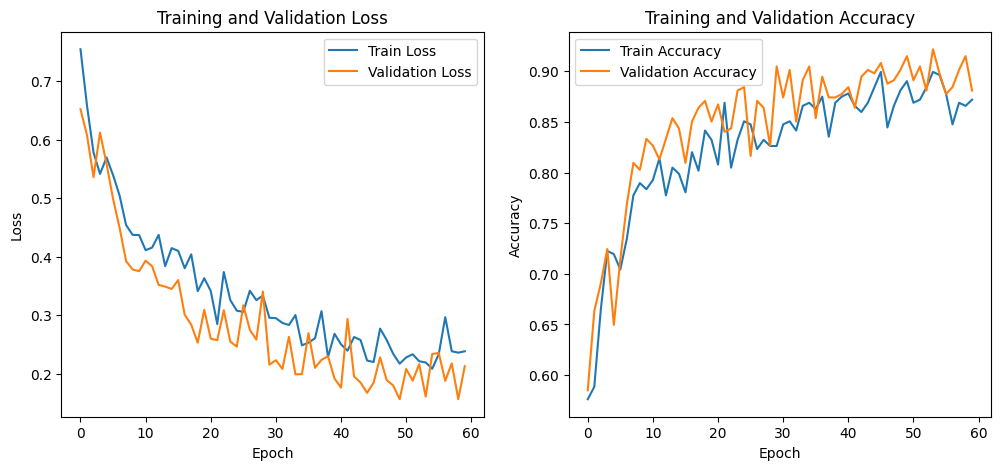

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Training parameters
num_epochs = 100
patience = 10  # Number of epochs to wait before stopping if no improvement
min_delta = 0.001  # Minimum change to qualify as an improvement

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

best_val_loss = float('inf')  # Initialize to infinity
early_stopping_counter = 0    # Count epochs without improvement

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / total
    val_accuracy = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Check for improvement in validation loss
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset the counter
        print("Validation loss improved. Saving model...")
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1
        print(f"No improvement for {early_stopping_counter} epoch(s).")

    # Stop training if patience is exceeded
    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Confusion Matrix:
[[131  17]
 [ 18 128]]


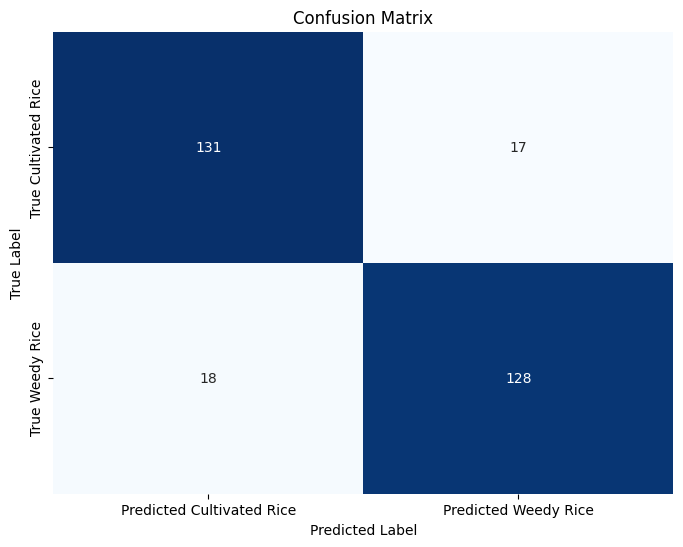


Metrics for each class:
Cultivated Rice: Precision = 0.8792, Recall = 0.8851, F-score = 0.8822
Weedy Rice: Precision = 0.8828, Recall = 0.8767, F-score = 0.8797


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_per_class(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
            outputs = model(inputs)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predictions
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Classification Report
    report = classification_report(all_labels, all_preds, target_names=['Cultivated Rice', 'Weedy Rice'], output_dict=True)

    # Extract metrics for each class
    metrics = {
        "Precision": [report['Cultivated Rice']['precision'], report['Weedy Rice']['precision']],
        "Recall": [report['Cultivated Rice']['recall'], report['Weedy Rice']['recall']],
        "F-score": [report['Cultivated Rice']['f1-score'], report['Weedy Rice']['f1-score']]
    }

    return cm, metrics

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Cultivated Rice', 'Predicted Weedy Rice'],
                yticklabels=['True Cultivated Rice', 'True Weedy Rice'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have trained your model and test_loader is defined
cm, metrics = evaluate_model_per_class(model, test_loader)

# Display the Confusion Matrix
print("Confusion Matrix:")
print(cm)
plot_confusion_matrix(cm)

# Display metrics for each class
print("\nMetrics for each class:")
print(f"Cultivated Rice: Precision = {metrics['Precision'][0]:.4f}, Recall = {metrics['Recall'][0]:.4f}, F-score = {metrics['F-score'][0]:.4f}")
print(f"Weedy Rice: Precision = {metrics['Precision'][1]:.4f}, Recall = {metrics['Recall'][1]:.4f}, F-score = {metrics['F-score'][1]:.4f}")

In [2]:
import torch

# Specify the path where you want to save the model
model_path = 'C:\Desktop\CDCS6A\CSP650\Testing and development\Experiment_2\AlexE2V3pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


NameError: name 'model' is not defined